In [7]:
import csv
import numpy as np
import torch
import math
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from collections import defaultdict

Load the training data. These are the first two PCs of the G-vector for a small RNA.

In [ ]:
in_path = "../example/data.csv"

pc1_vals = []
pc2_vals = []
indices = []

# Load using csv module
with open(in_path, "r", newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        indices.append(row["index"])
        pc1_vals.append(float(row["pc1"]))
        pc2_vals.append(float(row["pc2"]))

# Make a scatter plot (no styles/colors specified)
plt.figure();
plt.scatter(pc1_vals, pc2_vals, s=5);
plt.xlabel("PC1");
plt.ylabel("PC2");
plt.title("PCA Scatter");
plt.show();
plt.close();

Custom loader class.

In [2]:
class PCADataset:
    def __init__(self, csv_path):
        self.csv_path = Path(csv_path)
        self.data = []
        self._load()

    def _load(self):
        with self.csv_path.open("r", newline="") as f:
            reader = csv.DictReader(f)
            for row in reader:
                index = row["index"]
                pc1 = float(row["pc1"])
                pc2 = float(row["pc2"])
                T   = float(row.get("T", 1.0))
                T += np.random.random()*1e-1                
                self.data.append((index, pc1, pc2, T))

    def __len__(self):
        return len(self.data)

    def _perturb(self, val, scale=1e-1):
        noise = scale*(2*np.random.uniform() - 1)
        return val + noise
        
        

    def __getitem__(self, i):
        index, pc1, pc2, T = self.data[i]
        temps = np.array([[T]], dtype=float)        # (1, 1)
        coords = np.zeros((2, 2), dtype=float)      # (2, 2)
        coords[0, :] = [pc1, pc2]                   # PCA row
        coords[1, :] = [self._perturb(T) for _ in range(2)]       
        return index, torch.Tensor(temps), torch.Tensor(coords)

In [3]:
from tm.architectures.mlp import MLP
from tm.architectures.unet_1d import Unet1D

from tm.core.backbone import MLPBackbone, ConvBackbone
from tm.core.diffusion_process import VPDiffusion
from tm.core.prior import GlobalEquilibriumHarmonicPrior as Prior
from tm.core.diffusion_model import DiffusionTrainer, DiffusionSampler
from tm.core.utils import next_divisible_by_groups
from torch.utils.data import RandomSampler

In [4]:
train_loader = PCADataset(in_path)

In [5]:
full_shape = [1] + list(train_loader.__getitem__(0)[-1].shape)
full_shape

[1, 2, 2]

In [6]:
train_loader = PCADataset(in_path)

train_sampler = RandomSampler(train_loader)

Here I tested an MLP and my Franken-Unet. The Unet matches the prior better than the MLP while having a lower memory footprint -- though I did spend much more time optimizing the Unet compared to the MLP.

In [10]:
# model =MLP(dim=128, #recommend dim=128 if enough memory
#            num_resolutions=8,
#            mlp_hidden_mult=8,
#            dropout=0.05,
#            learned_variance=False,
#            self_condition=True,
#            resnet_block_groups=8,
#            learned_sinusoidal_cond=True,
#            channels=2
# )

# backbone = MLPBackbone(model=model,
#                        lr=1e-5,
#                        eval_mode="train",
#                        self_condition=True,
#                       )



model =Unet1D(dim=128, #recommend dim=128 if enough memory
           num_resolutions=4,
           self_condition=True,
           resnet_block_groups=8,
           learned_sinusoidal_cond=True,
           channels=2
)

# Backbone will automatically use CUDA if it is available -- otherwise CPU.
backbone = ConvBackbone(model=model,
                        data_shape=full_shape[-1],
                        target_shape=next_divisible_by_groups(full_shape[-1], 8),
                        num_dims=3,
                        lr=1e-5,
                        eval_mode="train",
                        self_condition=True,
                        interpolate=True
                      )

diffusion = VPDiffusion(num_diffusion_timesteps=10)

prior = Prior(shape=full_shape, channels_info={"coordinate": [0], "fluctuation": [1]})

Using device  cuda for TM


In [10]:
trainer = DiffusionTrainer(diffusion,
                           backbone,
                           train_loader,
                           prior,
                           model_dir='../example/models',
                           network_pred_type='noise',
                           train_sampler=train_sampler,
                           )

In [11]:
trainer.train(80, loss_type="l2", batch_size=256)

epoch: 0 | train loss: 1.604
epoch: 1 | train loss: 1.301
epoch: 2 | train loss: 1.203
epoch: 3 | train loss: 1.127
epoch: 4 | train loss: 1.100
epoch: 5 | train loss: 1.086
epoch: 6 | train loss: 1.072
epoch: 7 | train loss: 1.056
epoch: 8 | train loss: 1.046
epoch: 9 | train loss: 1.035
epoch: 10 | train loss: 1.020
epoch: 11 | train loss: 1.029
epoch: 12 | train loss: 1.018
epoch: 13 | train loss: 1.009
epoch: 14 | train loss: 1.008
epoch: 15 | train loss: 1.009
epoch: 16 | train loss: 1.013
epoch: 17 | train loss: 1.017
epoch: 18 | train loss: 1.005
epoch: 19 | train loss: 1.011
epoch: 20 | train loss: 1.016
epoch: 21 | train loss: 1.003
epoch: 22 | train loss: 1.010
epoch: 23 | train loss: 0.999
epoch: 24 | train loss: 0.999
epoch: 25 | train loss: 0.981
epoch: 26 | train loss: 0.994
epoch: 27 | train loss: 0.987
epoch: 28 | train loss: 0.993
epoch: 29 | train loss: 0.979
epoch: 30 | train loss: 0.987
epoch: 31 | train loss: 0.969
epoch: 32 | train loss: 1.012
epoch: 33 | train lo

KeyboardInterrupt: 

In [8]:
backbone.load_model('../example/models', epoch='latest')

load_state using device choice: cuda


In [9]:
diffusion = VPDiffusion(num_diffusion_timesteps=10) # time mesh does not have to be the same as during training
sampler = DiffusionSampler(diffusion, backbone, train_loader, prior, network_pred_type='noise')

Simple consistency test to verify that the model is working properly. Push the training data forward through the diffusion process to get prior (latent) representations. Verify that they are gaussian distributed (or at least close to). Then take the prior reps and use them as initial conditions for the generative process. If everything is working properly, then we should recover the training distribution. 

In [10]:
# Training data --> Prior reps (deterministic forward process)

output_dict = defaultdict(list)
direction = 'forward'
T = 1

# If OOM error reduce batch size
data_loader = torch.utils.data.DataLoader(train_loader, batch_size=512, shuffle=False, pin_memory=True)

for batch_index, (index, temperatures, b) in enumerate(tqdm(data_loader, desc="Processing batches")):
    # print(index)
    batch_size = b.size(0)
    for index_ in index:
        if index_ not in output_dict.keys():
            output_dict[index_] = {'target': [], 'prior': [], 'delta_log_pq': [], 'log_p': [], 'log_q': []}
    # else:
    #     output_dict[index] = {'target': [], 'prior': [], 'delta_log_pq': [], 'log_p': [], 'log_q': []}

    output_dict_ = sampler.sample_batch(x0=b, 
                                        mode=direction, 
                                        eta=0, # 0 is ODE, 1 is SDE
                                        gamma=0, # control some of the channels (0 is no control)
                                        batch_size=batch_size,
                                        temperatures=T, # can be scalar of vector (len is num samples)
                                        likelihood=True,
                                        control_dict={}, 
                                        pred_type='noise')

    for i_, index_ in enumerate(index):
        for k,v in output_dict_.items():
            output_dict[index_][k] = output_dict_[k][i_]

Processing batches:   0%|                                                                                                                                            | 0/10 [00:00<?, ?it/s]/home/lukas/micromamba/envs/thermomaps/lib/python3.11/site-packages/torch/nn/functional.py:4735: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_upsample_nearest_exact1d. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1762103288612/work/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  return torch._C._nn._upsample_nearest_exact1d(input, output_size, scale_factors)
Processing batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.06s/it]


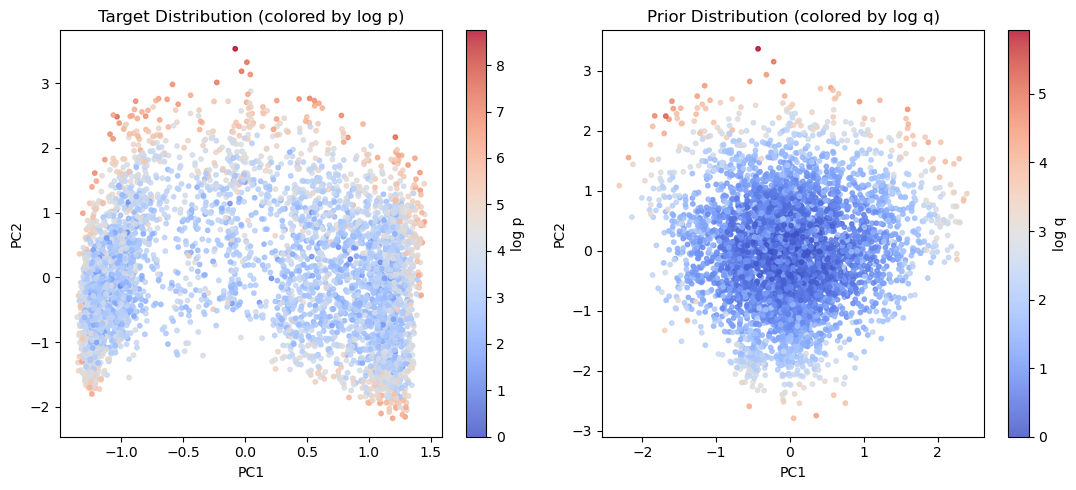

In [11]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
    if entry:
        try:
            targets.append(entry["target"][0])  # 0 - coordinates, 1 - temperatures
            priors.append(entry["prior"][0])
            logp.append(float(entry["log_p"]))
            logq.append(float(entry["log_q"]))
        except:
            None

logp = -np.array(logp)
logq = -np.array(logq)

logp -= min(logp)
logq -= min(logq)

targets, priors = np.array(targets), np.array(priors)
logp, logq = np.array(logp), np.array(logq)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

sc1 = axes[0].scatter(targets[:, 0], targets[:, 1], c=logp, cmap='coolwarm', s=10, alpha=0.8)
axes[0].set_title("Target Distribution (colored by log p)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label='log p')

sc2 = axes[1].scatter(priors[:, 0], priors[:, 1], c=logq, cmap='coolwarm', s=10, alpha=0.8)
axes[1].set_title("Prior Distribution (colored by log q)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
plt.colorbar(sc2, ax=axes[1], label='log q')

plt.tight_layout()
plt.show()


Save the prior reps.

In [8]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
        try:
            targets.append(entry["target"][None,:,:])  # 0 - coordinates, 1 - temperatures
            priors.append(entry["prior"][None,:,:])
            logp.append(float(entry["log_p"]))
            logq.append(float(entry["log_q"]))
        except:
            None
targets_ = np.array(targets).squeeze()
priors_ = np.array(priors).squeeze()


NameError: name 'output_dict' is not defined

In [13]:
np.save('prior_endpoints.npy', priors_)

In [10]:
priors_ = np.load('prior_endpoints.npy')

In [18]:
# Prior reps --> Training data (deterministic reverse process)

# Parameters
batch_size = 256
N = priors_.shape[0]     # or: N = priors_.shape[0]
T = 1
direction = "reverse"

output_dict = {}  # will hold N unique indices: 0..N-1

# Make sure N matches priors_
N = priors_.shape[0]
num_batches = math.ceil(N / batch_size)

for b_ix in tqdm(range(num_batches)):
    start = b_ix * batch_size
    end   = min(start + batch_size, N)
    bs    = end - start
    if bs <= 0:
        break

    # Slice this batch of prior points
    b_np = priors_[start:end]                 # shape (bs, ...)
    # If priors_ is numpy; if it's already torch, you can skip as_tensor
    b = torch.as_tensor(b_np, dtype=torch.float32)  # .to(device) if needed

    # Run sampler on this batch (push prior points backward)
    output_dict_batch = sampler.sample_batch(
        x0=b,
        mode=direction,
        eta=0,                  # 0 = ODE, 1 = SDE (if implemented inside)
        gamma=0,                # no control
        batch_size=bs,
        temperatures=T,         # scalar or vector; same as before
        likelihood=True,
        control_dict={},
        network_pred_type="noise",   # NOTE: use network_pred_type, not pred_type
    )

    # Store results with unique global indices
    # Assumes output_dict_batch fields have shape (bs, ...)
    for i in range(bs):
        idx = start + i
        output_dict[idx] = {
            "target":       output_dict_batch["target"][i],
            "prior":        output_dict_batch["prior"][i],
            "delta_log_pq": output_dict_batch["delta_log_pq"][i],
            "log_p":        output_dict_batch["log_p"][i],
            "log_q":        output_dict_batch["log_q"][i],
        }


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.21it/s]


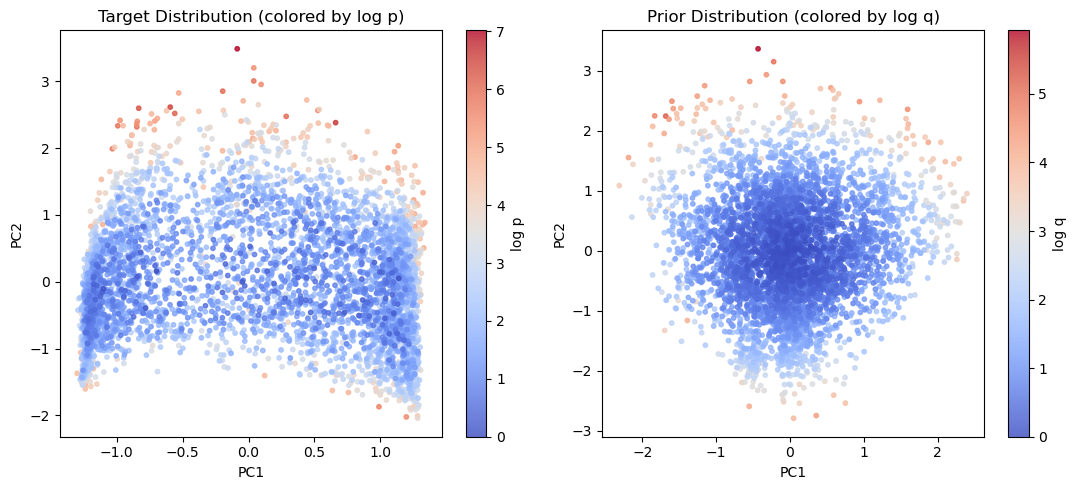

In [19]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
    try:
        targets.append(entry["target"][0])  # coordinate row
        priors.append(entry["prior"][0])
        logp.append(float(entry["log_p"]))
        logq.append(float(entry["log_q"]))
    except:
        None

logp = -np.array(logp)
logq = -np.array(logq)

logp -= min(logp)
logq -= min(logq)

targets, priors = np.array(targets), np.array(priors)
logp, logq = np.array(logp), np.array(logq)

idxs = np.argsort(logp)[::-1]

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

sc1 = axes[0].scatter(targets[idxs, 0], targets[idxs, 1], c=logp[idxs], cmap='coolwarm', s=10, alpha=0.8)
axes[0].set_title("Target Distribution (colored by log p)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label='log p')

idxs = np.argsort(logq)[::-1]

sc2 = axes[1].scatter(priors[idxs, 0], priors[idxs, 1], c=logq[idxs], cmap='coolwarm', s=10, alpha=0.8)
axes[1].set_title("Prior Distribution (colored by log q)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
plt.colorbar(sc2, ax=axes[1], label='log q')

plt.tight_layout()
plt.show()


The code below enables the user to generate samples from the training distribution by sampling from the prior.

In [9]:
import math
from tqdm import tqdm
import torch
import numpy as np

# Parameters
batch_size = 256
N = 5000
T = 0.1
direction = "reverse"

output_dict = {}  # will hold N unique indices: 0..N-1

# Make sure N matches priors_
N = priors_.shape[0]
num_batches = math.ceil(N / batch_size)

for b_ix in tqdm(range(num_batches)):
    start = b_ix * batch_size
    end   = min(start + batch_size, N)
    bs    = end - start
    if bs <= 0:
        break

    b = prior.sample(batch_size=bs, temperatures=T)

    # Run sampler on this batch (push prior points backward)
    output_dict_batch = sampler.sample_batch(
        x0=b,
        mode=direction,
        eta=0,                  # 0 = ODE, 1 = SDE (if implemented inside)
        gamma=0,                # no control
        batch_size=bs,
        temperatures=T,         # scalar or vector; same as before
        likelihood=True,
        control_dict={},
        network_pred_type="noise",   # NOTE: use network_pred_type, not pred_type
    )

    # Store results with unique global indices
    # Assumes output_dict_batch fields have shape (bs, ...)
    for i in range(bs):
        idx = start + i
        output_dict[idx] = {
            "target":       output_dict_batch["target"][i],
            "prior":        output_dict_batch["prior"][i],
            "delta_log_pq": output_dict_batch["delta_log_pq"][i],
            "log_p":        output_dict_batch["log_p"][i],
            "log_q":        output_dict_batch["log_q"][i],
        }


NameError: name 'priors_' is not defined

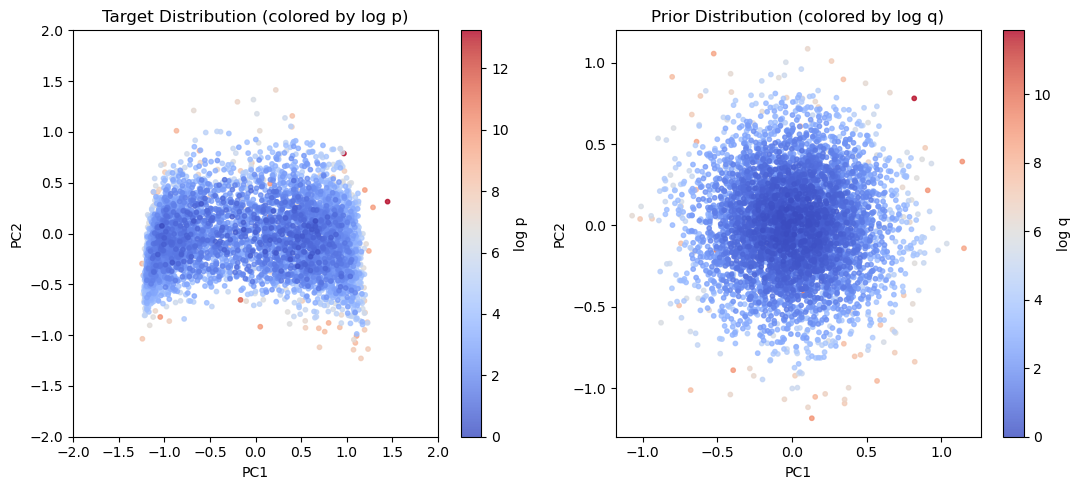

In [30]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
    try:
        targets.append(entry["target"][0])  # coordinate row
        priors.append(entry["prior"][0])
        logp.append(float(entry["log_p"]))
        logq.append(float(entry["log_q"]))
    except:
        None

logp = -np.array(logp)
logq = -np.array(logq)

logp -= min(logp)
logq -= min(logq)

targets, priors = np.array(targets), np.array(priors)
logp, logq = np.array(logp), np.array(logq)

idxs = np.argsort(logp)[::-1]

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

sc1 = axes[0].scatter(targets[idxs, 0], targets[idxs, 1], c=logp[idxs], cmap='coolwarm', s=10, alpha=0.8)
axes[0].set_title("Target Distribution (colored by log p)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label='log p')

idxs = np.argsort(logq)[::-1]

sc2 = axes[1].scatter(priors[idxs, 0], priors[idxs, 1], c=logq[idxs], cmap='coolwarm', s=10, alpha=0.8)
axes[1].set_title("Prior Distribution (colored by log q)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
plt.colorbar(sc2, ax=axes[1], label='log q')

axes[0].set_xlim(-2,2)
axes[0].set_ylim(-2,2)

plt.tight_layout()
plt.show()
